## Packages installations and imports
(Run this section to ensure smooth operation for the Notebook)

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt

## Overview Dataset

1. Data Structure

In [ ]:
import gdown

gdown.download_folder("https://drive.google.com/drive/folders/19DLS6ZrfsxVq4IrRycPKrtt1TQanV9Em?usp=sharing", quiet=False, use_cookies=False)

2025-05-16 03:20:59.132691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 03:20:59.258401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747340459.302436     379 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747340459.316217     379 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747340459.421384     379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Processing file 1tswGuA4JAO_fX8yQKlUTZoaXvHpeYnp8 meta_train.csv
Processing file 1Cz6q_m9fpAFePRZV6Ca2vMya4XvZDamX test_images.zip
Processing file 1tp1F1Xora43V5Ks3IjRaw40V3iAC6Wm2 train_images.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1tswGuA4JAO_fX8yQKlUTZoaXvHpeYnp8
To: /home/herom/data/meta_train.csv
100%|████████████████████████████████████████████████████████████████████████████████| 335k/335k [00:00<00:00, 1.30MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Cz6q_m9fpAFePRZV6Ca2vMya4XvZDamX
From (redirected): https://drive.google.com/uc?id=1Cz6q_m9fpAFePRZV6Ca2vMya4XvZDamX&confirm=t&uuid=6f5fe038-5538-46ab-853c-d2d201bf828f
To: /home/herom/data/test_images.zip
100%|████████████████████████████████████████████████████████████████████████████████| 274M/274M [00:24<00:00, 11.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1tp1F1Xora43V5Ks3IjRaw40V3iAC6Wm2
From (redirected): https://drive.google.com/uc?id=1tp1F1Xora43V5Ks3IjRaw40V3iAC6Wm2&confirm=t&uuid=1a93226c-a0ae-4676-94d6-801b0f7797af
To: /home/herom/data/train_i

['/home/herom/data/meta_train.csv',
 '/home/herom/data/test_images.zip',
 '/home/herom/data/train_images.zip']

In [ ]:
import zipfile
with zipfile.ZipFile('data/train_images.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [ ]:
with zipfile.ZipFile('data/test_images.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [ ]:
import pandas as pd
data = pd.read_csv('data/meta_train.csv')

data.head()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [ ]:
data['age'] = data['age'].astype('object')
data.describe(include='object')

,image_id,label,variety,age
count,10407,10407,10407,10407
unique,10407,10,10,18
top,110381.jpg,normal,ADT45,70
freq,1,1764,6992,3077


2. Check for Duplicated data

In [ ]:
print(data.isnull().sum())
print(data.duplicated().sum())

image_id    0
label       0
variety     0
age         0
dtype: int64
0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'bacterial_leaf_blight'),
  Text(1, 0, 'bacterial_leaf_streak'),
  Text(2, 0, 'bacterial_panicle_blight'),
  Text(3, 0, 'blast'),
  Text(4, 0, 'brown_spot'),
  Text(5, 0, 'dead_heart'),
  Text(6, 0, 'downy_mildew'),
  Text(7, 0, 'hispa'),
  Text(8, 0, 'normal'),
  Text(9, 0, 'tungro')])

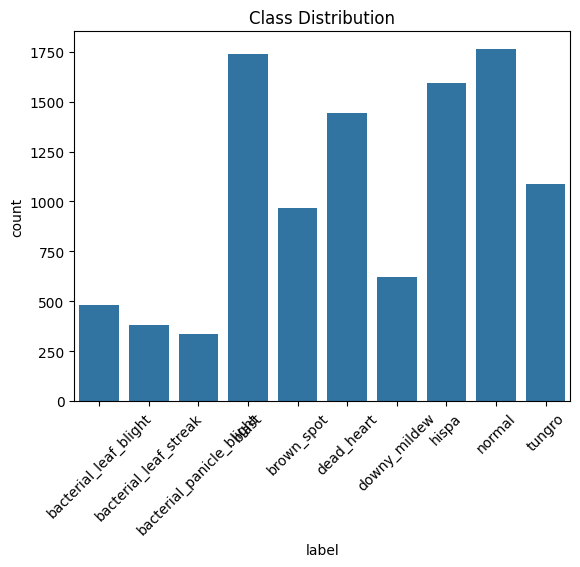

In [ ]:
import seaborn as sns
# Label feature distribution graph
sns.countplot(data=data, x='label')
plt.title("Class Distribution")
plt.xticks(rotation=45)

In [ ]:
data["label"].value_counts()

,count
label,
normal,1764
blast,1738
hispa,1594
dead_heart,1442
tungro,1088
brown_spot,965
downy_mildew,620
bacterial_leaf_blight,479
bacterial_leaf_streak,380


In [ ]:
# Check for image resolution of given dataset as well as all images' format
from PIL import Image
import os
from collections import Counter
from pathlib import Path

train_dir = "data/train_images"

# Traverse all subdirectories (classes)
image_sizes = []
image_formats = []

# Loop to go through all disease classes within the train_images folder
# and its images to collect image resolution and format
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)
                    image_formats.append(img.format)  # Add format into image_formats array
            except Exception as e:
                print(f"Error reading {image_path}: {e}")

# Image sizes summary
size_counts = Counter(image_sizes)
print("Most common image sizes:")
for size, count in size_counts.most_common():
    print(f"{size}: {count} images")

# Image formats summary
format_counts = Counter(image_formats)
print("\nMost common image formats:")
for fmt, count in format_counts.most_common():
    print(f"{fmt}: {count} images")


Most common image sizes:
(480, 640): 10403 images
(640, 480): 4 images

Most common image formats:
JPEG: 10407 images


In [ ]:
import random
from tensorflow.keras import layers
# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomBrightness(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

I0000 00:00:1747354365.905171     369 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Preparing Data

- Loading the Dataset

In [ ]:
# Load the image set
full_dataset_task1 = tf.keras.utils.image_dataset_from_directory(
    './data/train_images',
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=None
)

# Preview the dataset
for images, labels in full_dataset_task1.take(1):
    print(images.shape)
    print(labels.shape)
print(full_dataset_task1.class_names)

Found 10407 files belonging to 10 classes.
(224, 224, 3)
(10,)
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


2025-05-16 07:12:50.814560: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Splitting the Dataset

In [ ]:
# Calculate total samples
total_sample_task1 = full_dataset_task1.cardinality().numpy()
print(f"Total sample (Task 1): {total_sample_task1}")

# Calculate split sizes
train_size_task1 = int(0.8 * total_sample_task1)
val_size_task1 = total_sample_task1 - train_size_task1

# shuffle the full dataset
full_dataset_task1 = full_dataset_task1.shuffle(buffer_size=total_sample_task1, seed=42)

# Split
train_dataset_task1 = full_dataset_task1.take(train_size_task1)
val_dataset_task1 = full_dataset_task1.skip(train_size_task1)

# shuffle the train dataset
train_dataset_task1 = train_dataset_task1.shuffle(buffer_size=train_size_task1,
                                                  seed=42,
                                                  reshuffle_each_iteration=True)

# Divide the data to batch = 32
train_dataset_task1 = train_dataset_task1.batch(32)
val_dataset_task1 = val_dataset_task1.batch(32)

# Print sizes of data set by batchs
print(f"Train batches (Task 1): {train_dataset_task1.cardinality().numpy()}")
print(f"Validation batches (Task 1): {val_dataset_task1.cardinality().numpy()}")

# # Optimize the pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_task1 = train_dataset_task1.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_task1 = val_dataset_task1.cache().prefetch(buffer_size=AUTOTUNE)

Total sample (Task 1): 10407
Train batches (Task 1): 261
Validation batches (Task 1): 66


- Test dataset import for evaluation purposes

In [ ]:
# Getting test set to calculate prediction speed
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/test_images',
    labels=None,                  # No labels needed for prediction
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3469 files.


## Training Models

- Building the models

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, MobileNet, Xception
from tensorflow.keras import models, optimizers
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


EfficientNetB0_model_task1 = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,          # Exclude the final classification layer
    weights=None                # No pretrained weights
)

MobileNet_model_task1 = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,          # Exclude the final classification layer
    weights=None                # No pretrained weights
)

Xception_model_task1 = Xception(
    input_shape=(224, 224, 3),
    include_top=False,          # Exclude the final classification layer
    weights=None                # No pretrained weights
)

### MobileNet Model

- Hyper-Tuning and Developing Model

In [ ]:
# Function to build and hyper-tuning MobileNet model
def build_MobileNet_model_task1(hp):

    model = tf.keras.Sequential([
          data_augmentation,
          normalization_layer,
          MobileNet_model_task1,
          layers.GlobalAveragePooling2D(),

          # Apply L2 regularization on Dense layers
          layers.Dense(hp.Int('dense_units', 64, 256, step=64),
                       activation='relu'),

          layers.BatchNormalization(),  # Apply BatchNormalization
          layers.Dropout(hp.Float('dropout_rate', 0.1, 0.4, step=0.1)),  # Apply Dropout for additional regularization
          layers.Dense(10, activation='softmax')  # Output layer
    ])

    # Apply Learning rate
    learning_rate = hp.Float('learning_rate', 5e-4, 5e-3, sampling='log')

    # Apply Optimizer Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Apply Label smmoothing
    label_smoothing = hp.Float('label_smoothing', min_value=0.0, max_value=0.05, step=0.01)

    # Complie the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=['accuracy']
    )

    return model

# Aplly Random Search tuning
MobileNet_task1_tuner = kt.RandomSearch(
    build_MobileNet_model_task1,
    objective='val_accuracy',
    max_trials=10,                   # Number of different hyperparameter sets to try
    directory='data/tuningTask1/MobileNet',
    project_name='MobileNet_tune',
    seed=42                         # For reproducibility
)

# Apply Early Stop
early_stop_MobileNet_model_task1 = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True)

# Aplly Reduce Learning Rate
reduce_lr_MobileNet_model_task1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1
)

Reloading Tuner from data/tuningTask1/MobileNet/MobileNet_tune/tuner0.json


- Training and Searching the best Model

In [ ]:
MobileNet_task1_tuner.search(
    train_dataset_task1,
    validation_data=val_dataset_task1,
    epochs=50,
    callbacks=[early_stop_MobileNet_model_task1, reduce_lr_MobileNet_model_task1],
)

Trial 10 Complete [00h 10m 05s]
val_accuracy: 0.978866457939148

Best val_accuracy So Far: 0.9846301674842834
Total elapsed time: 04h 33m 22s


- Geting and Saving the best model

In [ ]:
# Track the best model:
best_MobileNet_model_task1 = MobileNet_task1_tuner.get_best_models(1)[0]
best_MobileNet_model_task1.summary()
best_MobileNet_model_task1.save("best_MobileNet_model_task_1.keras")

# Print best hyperparameters:
best_para_MobileNet_model_task1_hp = MobileNet_task1_tuner.get_best_hyperparameters(1)[0]

hp_values = best_para_MobileNet_model_task1_hp.values

print("Dense Units:", hp_values.get("dense_units"))
print("Learning Rate:", hp_values.get("learning_rate"))
print("Dropout Rate:", hp_values.get("dropout_rate"))
print("Label Smoothing:", hp_values.get("label_smoothing"))

/home/herom/lintf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 176 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │       196,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,428,362 (13.08 MB)

 Trainable params: 3,406,090 (12.99 MB)

 Non-trainable params: 22,272 (87.00 KB)

Dense Units: 192
Learning Rate: 0.0010157264435346853
Dropout Rate: 0.1
Label Smoothing: 0.02


### EfficientNetB0 Model

- Hyper-Tuning and Developing Model

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to build and hyper-tuning the EfficientNetB0 model
def build_EfficientNetB0_model_task1(hp):

    model = tf.keras.Sequential([
          data_augmentation,
          normalization_layer,
          EfficientNetB0_model_task1,
          layers.GlobalAveragePooling2D(),

          layers.Dense(hp.Int('dense_units', 64, 256, step=64),
                       activation='relu'),

          layers.BatchNormalization(),  # Aplly BatchNormalization
          layers.Dropout(hp.Float('dropout_rate', 0.1, 0.4, step=0.1)),  # Dropout for additional regularization
          layers.Dense(10, activation='softmax')  # Output layer
    ])

    # Apply Learning Rate
    learning_rate = hp.Float('learning_rate', 5e-4, 5e-3, sampling='log')

    # Aplly optimizer Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Aplly label smoothing
    label_smoothing = hp.Float('label_smoothing', min_value=0.0, max_value=0.05, step=0.01)

    # Complie the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=['accuracy']
    )

    return model

# Aplly Random Search tuning
EfficientNetB0_task1_tuner = kt.RandomSearch(
    build_EfficientNetB0_model_task1,
    objective='val_accuracy',
    max_trials=10,                   # Number of different hyperparameter sets to try
    directory='data/tuningTask1/EfficientNetB0',
    project_name='EfficientNetB0_tune',
    seed=42                         # For reproducibility
)

# Aplly Early Stop
early_stop_EfficientNetB0_model_task1 = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True)

# Apply Reduce Learning Rate
reduce_lr_EfficientNetB0_model_task1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1
)

Reloading Tuner from data/tuningTask1/EfficientNetB0/EfficientNetB0_tune/tuner0.json


- Training and Searching for the best Model

In [ ]:
EfficientNetB0_task1_tuner.search(
    train_dataset_task1,
    validation_data=val_dataset_task1,
    epochs=20,
    callbacks=[early_stop_EfficientNetB0_model_task1, reduce_lr_EfficientNetB0_model_task1]
)

Trial 10 Complete [00h 09m 11s]
val_accuracy: 0.9817483425140381

Best val_accuracy So Far: 0.9870316982269287
Total elapsed time: 04h 14m 27s


- Getting and Saving the best Model

In [ ]:
# Track the best model:
best_EfficientNetB0_model_task1 = EfficientNetB0_task1_tuner.get_best_models(1)[0]
best_EfficientNetB0_model_task1.summary()
#best_EfficientNetB0_model_task1.save("best_EfficientNetB0_model_task_1.keras")

# Print best hyperparameters:
best_EfficientNetB0_model_task1_hp = EfficientNetB0_task1_tuner.get_best_hyperparameters(1)[0]

hp_values = best_EfficientNetB0_model_task1_hp.values

print("Dense Units:", hp_values.get("dense_units"))
print("Learning Rate:", hp_values.get("learning_rate"))
print("Dropout Rate:", hp_values.get("dropout_rate"))
print("Label Smoothing:", hp_values.get("label_smoothing"))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,341 (16.08 MB)

 Trainable params: 4,173,062 (15.92 MB)

 Non-trainable params: 42,279 (165.16 KB)

Dense Units: 128
Learning Rate: 0.001411936412718108
Dropout Rate: 0.4
Label Smoothing: 0.02


In [ ]:
EfficientNetB0_task1_tuner.results_summary()

Results summary
Results in data/tuningTask1/EfficientNetB0/EfficientNetB0_tune
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
l2_lambda: 1.9473369534115484e-05
dense_units: 128
dropout_rate: 0.30000000000000004
learning_rate: 0.000791696473954755
label_smoothing: 0.04
Score: 0.9870316982269287

Trial 06 summary
Hyperparameters:
l2_lambda: 1.4023399602325875e-05
dense_units: 128
dropout_rate: 0.4
learning_rate: 0.001411936412718108
label_smoothing: 0.02
Score: 0.9870316982269287

Trial 07 summary
Hyperparameters:
l2_lambda: 0.00039648863050186525
dense_units: 256
dropout_rate: 0.1
learning_rate: 0.0009342457214524525
label_smoothing: 0.03
Score: 0.9865514039993286

Trial 2 summary
Hyperparameters:
l2_lambda: 0.0009051274097824621
dense_units: 192
dropout_rate: 0.4
learning_rate: 0.0006156159431391849
label_smoothing: 0.05
Score: 0.9860711097717285

Trial 3 summary
Hyperparameters:
l2_lambda: 1.2165541012624622e-05
dense_units: 1

### Xception Model

- Hyper-Tuning and Developing Model

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Function to build and hyper-tuning MobileNet model
def build_Xception_model_task1(hp):

    model = tf.keras.Sequential([
          data_augmentation,
          normalization_layer,
          Xception_model_task1,
          layers.GlobalAveragePooling2D(),

          # Apply L2 regularization on Dense layers
          layers.Dense(hp.Int('dense_units', 64, 256, step=64),
                       activation='relu'),

          layers.BatchNormalization(),  # Apply BatchNormalization
          layers.Dropout(hp.Float('dropout_rate', 0.1, 0.4, step=0.1)),  # Dropout for additional regularization
          layers.Dense(10, activation='softmax')  # Output layer
    ])

    # Apply Learning Rate
    learning_rate = hp.Float('learning_rate', 5e-4, 5e-3, sampling='log')

    # Apply Optimizer Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Apply label smoothing
    label_smoothing = hp.Float('label_smoothing', min_value=0.0, max_value=0.05, step=0.01)

    # Complie the model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=['accuracy']
    )

    return model
# Aplly Random Search tuning
Xception_task1_tuner = kt.RandomSearch(
    build_Xception_model_task1,
    objective='val_accuracy',
    max_trials=10,                   # Number of different hyperparameter sets to try
    directory='data/tuningTask1/Xception',
    project_name='Xception_tune',
    seed=42                         # For reproducibility
)

# Apply Early Stop
early_stop_Xception_model_task1 = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True)

# Aplly Reduce Learning Rate
reduce_lr_Xception_model_task1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1
)

Reloading Tuner from data/tuningTask1/Xception/Xception_tune/tuner0.json


- Training and Searching for the best Model

In [ ]:
Xception_task1_tuner.search(
    train_dataset_task1,
    validation_data=val_dataset_task1,
    epochs=50,
    callbacks=[early_stop_Xception_model_task1, reduce_lr_Xception_model_task1]
)

- Getting and Saving the best Model

In [ ]:
# Track the best model:
best_Xception_model_task1 = Xception_task1_tuner.get_best_models(1)[0]
best_Xception_model_task1.summary()
best_Xception_model_task1.save("best_Xception_model_task_1.keras")

# Print best hyperparameters:
best_Xception_model_task1_hp = Xception_task1_tuner.get_best_hyperparameters(1)[0]
hp_values = best_Xception_model_task1_hp.values

print("Dense Units:", hp_values.get("dense_units"))
print("Learning Rate:", hp_values.get("learning_rate"))
print("Dropout Rate:", hp_values.get("dropout_rate"))
print("Label Smoothing:", hp_values.get("label_smoothing"))

/home/herom/lintf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,125,554 (80.59 MB)

 Trainable params: 21,070,770 (80.38 MB)

 Non-trainable params: 54,784 (214.00 KB)

Dense Units: 128
Learning Rate: 0.001299313657989077
Dropout Rate: 0.2
Label Smoothing: 0.0


In [ ]:
Xception_task1_tuner.results_summary()

Results summary
Results in data/tuningTask1/Xception/Xception_tune
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
l2_lambda: 0.0007177664122743156
dense_units: 128
dropout_rate: 0.2
learning_rate: 0.001299313657989077
label_smoothing: 0.0
Score: 0.9870316982269287

Trial 3 summary
Hyperparameters:
l2_lambda: 1.2165541012624622e-05
dense_units: 192
dropout_rate: 0.1
learning_rate: 0.0010157264435346853
label_smoothing: 0.02
Score: 0.9817483425140381

Trial 0 summary
Hyperparameters:
l2_lambda: 0.00019004375238737127
dense_units: 64
dropout_rate: 0.2
learning_rate: 0.0009350727883249913
label_smoothing: 0.05
Score: 0.9755043387413025

Trial 1 summary
Hyperparameters:
l2_lambda: 5.0546665575067195e-05
dense_units: 192
dropout_rate: 0.1
learning_rate: 0.0015721955876355394
label_smoothing: 0.01
Traceback (most recent call last):
  File "/home/herom/lintf/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, i

## Evaluation Results and Final Training Session

1. Build all functions to calculate F1 and F1 per class

In [ ]:
# Function to extract labels and preds
def extract_labels_and_preds(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.append(labels.numpy())
        y_pred.append(preds)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return y_true, y_pred

In [ ]:
# Function to evaluate by f1
from sklearn.metrics import f1_score
def evaluate_f1(model, val_dataset, average='macro'):
    y_true, y_pred = extract_labels_and_preds(model, val_dataset)

    # Convert one-hot encoded labels to class indices
    y_true = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    return f1_score(y_true, y_pred_classes, average=average)

In [ ]:
# Function to evaluate by f1 per class
from sklearn.metrics import classification_report
def evaluate_f1_per_class(model, val_dataset, target_names=None):
    y_true, y_pred = extract_labels_and_preds(model, val_dataset)

    # Convert one-hot labels to class indices
    y_true = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    report = classification_report(
        y_true,
        y_pred_classes,
        target_names=target_names,
        digits=4
    )
    print(report)

In [ ]:
# Load trained model
from tensorflow.keras.models import load_model
best_EfficientNetB0_model_task_1 = load_model("best_EfficientNetB0_model_task_1.keras")
best_MobileNet_model_task_1 = load_model("best_MobileNet_model_task_1.keras")
best_Xception_model_task_1 = load_model("best_Xception_model_task_1.keras")

/home/herom/lintf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 176 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/herom/lintf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2. Calculate F1 Score for all models

In [ ]:
print("F1 Score of EfficientNetB0 model: ", evaluate_f1(best_EfficientNetB0_model_task_1, val_dataset_task1))

F1 Score of EfficientNetB0 model:  0.986250357928615


In [ ]:
print("F1 Score of MobileNet model: ", evaluate_f1(best_MobileNet_model_task_1, val_dataset_task1))

F1 Score of MobileNet model:  0.9845610942558753


2025-05-16 10:44:31.943588: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print("F1 Score of Xception model: ", evaluate_f1(best_Xception_model_task_1, val_dataset_task1))

F1 Score of Xception model:  0.9877074459583417


3. Calculate F1 Score per class for all models

In [ ]:
evaluate_f1_per_class(best_EfficientNetB0_model_task_1, val_dataset_task1)

              precision    recall  f1-score   support

           0     0.9806    1.0000    0.9902       101
           1     0.9859    0.9859    0.9859        71
           2     1.0000    1.0000    1.0000        60
           3     0.9662    0.9942    0.9800       345
           4     0.9896    0.9646    0.9770       198
           5     1.0000    0.9963    0.9981       267
           6     0.9704    0.9357    0.9527       140
           7     0.9969    0.9908    0.9938       325
           8     0.9861    0.9972    0.9916       355
           9     1.0000    0.9864    0.9931       220

    accuracy                         0.9870      2082
   macro avg     0.9876    0.9851    0.9863      2082
weighted avg     0.9871    0.9870    0.9870      2082



2025-05-15 21:10:21.828466: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
evaluate_f1_per_class(best_MobileNet_model_task_1, val_dataset_task1)

              precision    recall  f1-score   support

           0     0.9901    0.9901    0.9901       101
           1     1.0000    0.9859    0.9929        71
           2     1.0000    1.0000    1.0000        60
           3     0.9606    0.9884    0.9743       345
           4     0.9948    0.9747    0.9847       198
           5     0.9962    0.9925    0.9944       267
           6     0.9424    0.9357    0.9391       140
           7     0.9969    0.9877    0.9923       325
           8     0.9915    0.9915    0.9915       355
           9     0.9864    0.9864    0.9864       220

    accuracy                         0.9846      2082
   macro avg     0.9859    0.9833    0.9846      2082
weighted avg     0.9848    0.9846    0.9847      2082



In [ ]:
evaluate_f1_per_class(best_Xception_model_task_1, val_dataset_task1)

              precision    recall  f1-score   support

           0     0.9901    0.9901    0.9901       101
           1     1.0000    1.0000    1.0000        71
           2     1.0000    1.0000    1.0000        60
           3     0.9607    0.9913    0.9757       345
           4     0.9799    0.9848    0.9824       198
           5     1.0000    0.9963    0.9981       267
           6     1.0000    0.9214    0.9591       140
           7     0.9938    0.9908    0.9923       325
           8     0.9916    0.9944    0.9930       355
           9     0.9864    0.9864    0.9864       220

    accuracy                         0.9870      2082
   macro avg     0.9902    0.9855    0.9877      2082
weighted avg     0.9873    0.9870    0.9870      2082



4. Calculate Prediction Latency for all models

In [ ]:
import time
# Function to calculate the prediction time
def calculate_prediction_time(model, dataset):
  # Warm-up Run
  for batch in dataset.take(1):
      _ = model.predict(batch, verbose=0)

  # Measure Prediction Time
  start = time.time()
  total_images = 0

  for batch in dataset:
      _ = model.predict(batch, verbose=0)
      total_images += batch.shape[0]

  end = time.time()

  # Results
  total_time = end - start
  per_image_time = (total_time / total_images) * 1000  # in ms

  print(f"Predicted {total_images} images in {total_time:.2f} seconds")
  print(f"Average prediction time per image: {per_image_time:.2f} ms")

In [ ]:
print("EfficientNetB0:")
calculate_prediction_time(best_EfficientNetB0_model_task_1, test_dataset)

EfficientNetB0:
Predicted 3469 images in 7.31 seconds
Average prediction time per image: 2.11 ms


In [ ]:
print("MobileNet:")
calculate_prediction_time(best_MobileNet_model_task_1, test_dataset)

MobileNet:


2025-05-16 10:45:07.540247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Predicted 3469 images in 5.79 seconds
Average prediction time per image: 1.67 ms


In [ ]:
print("Xception:")
calculate_prediction_time(best_Xception_model_task_1, test_dataset)

Xception:


2025-05-16 10:45:24.887023: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Predicted 3469 images in 10.08 seconds
Average prediction time per image: 2.91 ms


5. Train final chosen model

In [ ]:
final_EfficientNetB0_model_task_1_history = best_EfficientNetB0_model_task_1.fit(train_dataset_task1, validation_data=val_dataset_task1, epochs=30, callbacks=[early_stop_EfficientNetB0_model_task1, reduce_lr_EfficientNetB0_model_task1])

Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 199ms/step - accuracy: 0.9877 - loss: 0.1843 - val_accuracy: 0.9649 - val_loss: 0.2638 - learning_rate: 0.0014
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - accuracy: 0.9854 - loss: 0.1940 - val_accuracy: 0.9673 - val_loss: 0.2461 - learning_rate: 0.0014
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 194ms/step - accuracy: 0.9836 - loss: 0.2009 - val_accuracy: 0.9717 - val_loss: 0.2327 - learning_rate: 0.0014
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.9915 - loss: 0.1757 - val_accuracy: 0.9736 - val_loss: 0.2374 - learning_rate: 0.0014
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 50s 190ms/step - accuracy: 0.9900 - loss: 0.1818 - val_accuracy: 0.9846 - val_loss: 0.1976 - learning_rate: 0.0014
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 50s 190ms/step - accuracy: 0.9853 - loss: 0.1922 - val_accuracy: 0.9774 - val_loss: 0.2279 - learning_rate: 0.0014
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.9

In [ ]:
# Save the final model for prediction use
best_EfficientNetB0_model_task_1.save('final_EfficientNetB0_model_task_1.keras')

6. Plot the final model's training session

In [ ]:
import matplotlib.pyplot as plt
# Function to Plotting the Model
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy', model_name='None'):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy or Other Metric
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metric, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'ro-', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    plt.tight_layout()
    plt.show()


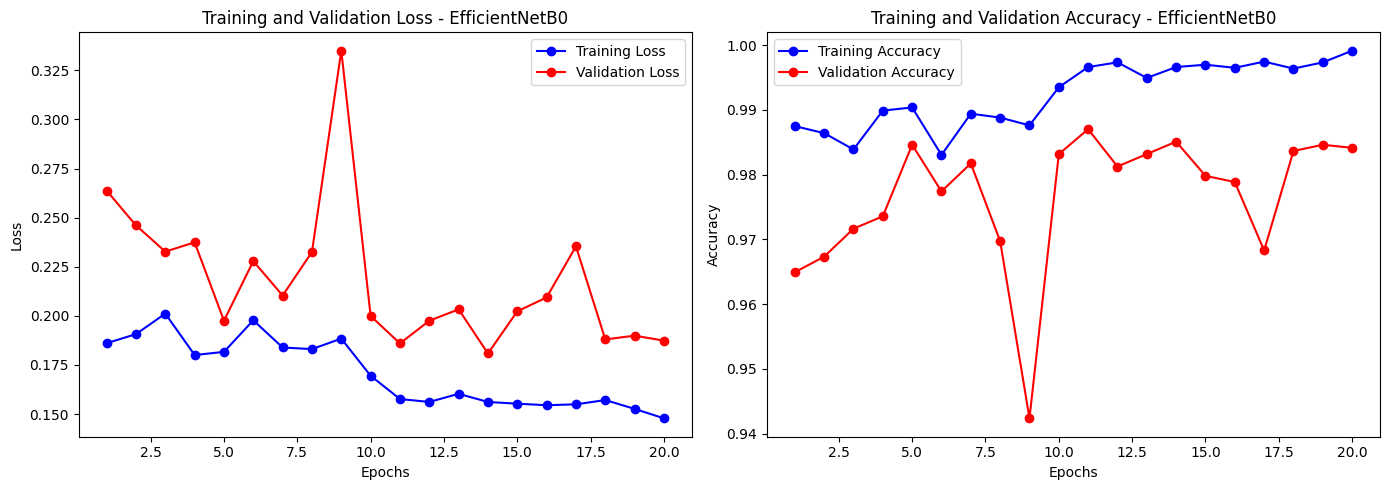

In [ ]:
plot_learning_curve(final_EfficientNetB0_model_task_1_history.history['loss'], final_EfficientNetB0_model_task_1_history.history['val_loss'],
                    final_EfficientNetB0_model_task_1_history.history['accuracy'], final_EfficientNetB0_model_task_1_history.history['val_accuracy'],
                    metric_name='Accuracy', model_name="EfficientNetB0")